In [252]:
%run Package_AND_Parameter.ipynb
%run Features_Calculation.ipynb
%run Smoothing.ipynb
gc.enable()

# Read Data

In [253]:
raw = pd.read_csv('E:/七天/0703_YiAn_emf1.csv', header=None)
len(raw)

9523200

In [254]:
# read data / cropping
raw = raw.values.flatten() * (900 / 4096)

In [255]:
len(raw)

9523200

In [256]:
# Extract EEG
eeg = mne.filter.filter_data(raw, sfreq=sfreq, l_freq=0.5, h_freq=30)

Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.610 sec)



In [257]:
len(eeg)

9523200

In [258]:
# resampling
df = pd.DataFrame()
df['EEG Fpz-Cz'] = signal.resample(eeg,int(sfreq*(len(raw)/512))).flatten()

In [259]:
df

,EEG Fpz-Cz
0,9.115258
1,17.674779
2,14.239071
3,8.700454
4,19.310743
...,...
1859995,1.775832
1859996,3.865781
1859997,-5.629421
1859998,-2.008005


In [260]:
index = []
for ep in range(int(len(df['EEG Fpz-Cz'])/(ep_duration*sfreq))):
    for time in range(int(ep_duration*sfreq)):
        index.append((ep,10*time))

Multi_idx = pd.MultiIndex.from_tuples(index,names=['epoch','time'])

df.columns.name = 'channel'
df.index = Multi_idx

In [261]:
df.head()

channel     EEG Fpz-Cz
epoch time            
0     0       9.115258
      10     17.674779
      20     14.239071
      30      8.700454
      40     19.310743

# Denoise

# Format

In [262]:
# data balance
con_len = list(
    df.groupby(level=['epoch']).count()['EEG Fpz-Cz'] /
    (ep_duration * sfreq))  # epochs
drop_len = np.floor(con_len[-1] - np.mean(con_len[:4]))  # epochs

star = ((int(np.floor(drop_len / 2) * (ep_duration * sfreq))) //
        int(int(smoothing_factor) * ep_duration * sfreq)) * int(
            int(smoothing_factor) * ep_duration * sfreq)
end = int(
    (np.sum(con_len) - np.floor(drop_len / 2)) * (ep_duration * sfreq))
end = end - ((end - star) % int(smoothing_factor * ep_duration * sfreq))

df = df[star:end]

# Basic Filter
"""
df['EEG Fpz-Cz'] = mne.filter.filter_data(raw,
                                          sfreq=sfreq,
                                          l_freq=0.5,
                                          h_freq=30)
"""
# 5 frequency bands
df['EEG Fpz-Cz Delta'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                                sfreq=100,
                                                l_freq=0.5,
                                                h_freq=4.5)
df['EEG Fpz-Cz Theta'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                                sfreq=100,
                                                l_freq=4.5,
                                                h_freq=8.5)
df['EEG Fpz-Cz Alpha'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                                sfreq=100,
                                                l_freq=8.5,
                                                h_freq=11.5)
df['EEG Fpz-Cz Sigma'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                                sfreq=100,
                                                l_freq=11.5,
                                                h_freq=15.5)
df['EEG Fpz-Cz Beta'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                               sfreq=100,
                                               l_freq=15.5,
                                               h_freq=30)

Setting up band-pass filter from 0.5 - 4.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Filter length: 661 samples (6.610 sec)



C:\Users\vita7\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Setting up band-pass filter from 4.5 - 8.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 8.50 Hz
- Upper transition bandwidth: 2.12 Hz (-6 dB cutoff frequency: 9.56 Hz)
- Filter length: 165 samples (1.650 sec)



C:\Users\vita7\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Setting up band-pass filter from 8.5 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.50
- Lower transition bandwidth: 2.12 Hz (-6 dB cutoff frequency: 7.44 Hz)
- Upper passband edge: 11.50 Hz
- Upper transition bandwidth: 2.88 Hz (-6 dB cutoff frequency: 12.94 Hz)
- Filter length: 155 samples (1.550 sec)



C:\Users\vita7\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 11.50
- Lower transition bandwidth: 2.88 Hz (-6 dB cutoff frequency: 10.06 Hz)
- Upper passband edge: 15.50 Hz
- Upper transition bandwidth: 3.88 Hz (-6 dB cutoff frequency: 17.44 Hz)
- Filter length: 115 samples (1.150 sec)



C:\Users\vita7\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Setting up band-pass filter from 16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.50
- Lower transition bandwidth: 3.88 Hz (-6 dB cutoff frequency: 13.56 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 85 samples (0.850 sec)



C:\Users\vita7\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [263]:
df.head()

channel     EEG Fpz-Cz  EEG Fpz-Cz Delta  EEG Fpz-Cz Theta  EEG Fpz-Cz Alpha  \
epoch time                                                                     
0     0       9.115258      3.275158e-15      1.776357e-15      1.776357e-15   
      10     17.674779     -9.616702e-01      1.702194e+00      2.013231e+00   
      20     14.239071     -1.881413e+00      2.944464e+00      3.305904e+00   
      30      8.700454     -2.715775e+00      3.406528e+00      3.394190e+00   
      40     19.310743     -3.423300e+00      2.973725e+00      2.176913e+00   

channel     EEG Fpz-Cz Sigma  EEG Fpz-Cz Beta  
epoch time                                     
0     0        -8.881784e-16    -2.664535e-15  
      10        1.726843e+00     5.488082e+00  
      20        2.219935e+00    -1.086573e+00  
      30        1.279242e+00    -2.462842e+00  
      40       -1.323764e-01     1.121222e+00

# FEATURE CALCULATION

In [264]:
# multi processing
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=mp.cpu_count())(delayed(func)(group)
                                             for name, group in dfGrouped)
    return pd.concat(retLst, axis=1).T

In [265]:
def Features_Calculate(df):
    grouped = df.groupby(level=['epoch'])
    temps = []
    """======================================================================================================================="""
    temps.append(grouped.std())
    temps.append(
        applyParallel(
            grouped,
            lambda x: pd.Series(univariate.compute_ptp_amp(x.T.values))))
    temps.append(
        applyParallel(grouped, lambda x: x.apply(Power, sfreq=100, axis=0)))

    temps.append(applyParallel(grouped, lambda x: x.apply(Spect_slop, axis=0)))

    temps.append(
        applyParallel(grouped, lambda x: x.apply(Mean_frequency, axis=0)))
    temps.append(
        applyParallel(
            grouped, lambda x: pd.Series(
                univariate.compute_hjorth_complexity(x.T.values))))
    temps.append(
        applyParallel(
            grouped, lambda x: x.apply(spectral_entropy,
                                       sf=sfreq,
                                       method='welch',
                                       normalize=False,
                                       axis=0)))
    temps.append(
        applyParallel(
            grouped, lambda x: x.apply(
                svd_entropy, order=3, delay=1, normalize=False, axis=0)))
    temps.append(
        applyParallel(grouped,
                      lambda x: x.apply(sample_entropy, order=2, axis=0)))
    temps.append(
        applyParallel(grouped, lambda x: x.apply(AutoCorr, k=1, axis=0)))
    """================================================================================"""

    res = pd.concat(temps, axis=1)
    cols = [(i, j) for i in funcs_n for j in six_bands_n]
    res.columns = pd.MultiIndex.from_tuples(tuples=cols,
                                            names=['Function', 'Band'])
    res.index.names = ['epoch']

    return res

In [266]:
train_X = Features_Calculate(df)

In [267]:
# Feature cross
lev1_comblist = list(combinations(six_bands_n, r=2))

for fes in funcs_n:
    cInd = int((funcs_n.index(fes) + 1) * len(six_bands_n) +
               funcs_n.index(fes) * len(ratio_n))

    i = 0
    for rn, coms in zip(ratio_n, lev1_comblist):
        ncol = (fes, rn)
        nval = train_X[(fes, coms[1])] / train_X[(fes, coms[0])]
        train_X.insert(loc=(cInd + i), column=ncol, value=nval)
        i = i + 1

        del rn, coms, ncol, nval
    del fes
gc.collect()
train_X.head()

Function        STD                                                     \
Band     EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta EEG Fpz-Cz Alpha   
epoch                                                                    
0         13.671440        10.351921         8.014609         3.816722   
1         10.661066         8.484853         5.848859         2.234185   
2         10.833179         8.084077         6.482207         3.036601   
3         12.974246         9.874813         7.481862         4.256017   
4         12.232891         9.451097         7.435710         3.167362   

Function                                                                 \
Band     EEG Fpz-Cz Sigma EEG Fpz-Cz Beta EEG Fpz-Cz DOR EEG Fpz-Cz TOR   
epoch                                                                     
0                3.161183        5.403106       0.757193       0.586230   
1                2.153613        4.303240       0.795873       0.548619   
2                2.344976        4.224407       0.746233       0.598366   
3                3.832374        4.366159       0.761109       0.576670   
4                2.976489        4.586915       0.772597       0.607846   

Function                                ...       AutoCorr                 \
Band     EEG Fpz-Cz AOR EEG Fpz-Cz SOR  ... EEG Fpz-Cz TDR EEG Fpz-Cz ADR   
epoch                                   ...                                 
0              0.279175       0.231225  ...       0.959439       0.840060   
1              0.209565       0.202007  ...       0.966874       0.827315   
2              0.280306       0.216462  ...       0.953623       0.844640   
3              0.328036       0.295383  ...       0.946072       0.841128   
4              0.258922       0.243319  ...       0.964840       0.834003   

Function                                                              \
Band     EEG Fpz-Cz SDR EEG Fpz-Cz BDR EEG Fpz-Cz ATR EEG Fpz-Cz STR   
epoch                                                                  
0              0.693790       0.048442       0.875575       0.723121   
1              0.674836       0.045565       0.855659       0.697957   
2              0.678874       0.025879       0.885717       0.711890   
3              0.672100       0.198352       0.889075       0.710411   
4              0.667507       0.142151       0.864395       0.691832   

Function                                                              
Band     EEG Fpz-Cz BTR EEG Fpz-Cz SAR EEG Fpz-Cz BAR EEG Fpz-Cz BSR  
epoch                                                                 
0              0.050490       0.825881       0.057665       0.069823  
1              0.047126       0.815695       0.055075       0.067520  
2              0.027137       0.803744       0.030639       0.038120  
3              0.209659       0.799046       0.235817       0.295123  
4              0.147331       0.800365       0.170444       0.212958  

[5 rows x 210 columns]

## Pick

In [268]:
fn = pd.read_csv('features_name_dataframe.csv',header=0)
fn_ = [(i,j) for i,j in zip(fn['function'],fn['band'])]
fn.head()
train_X = train_X[fn_]

## Encoding

In [269]:
# Encoding
teX = StandardScaler().fit_transform(train_X)
estimator = LinearDiscriminantAnalysis()
print(estimator.get_params)
print(teX.shape)

<bound method BaseEstimator.get_params of LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)>
(1860, 23)


In [270]:
pickle_in = open('LDA_BASIC.pickle', 'rb')
clf = pickle.load(pickle_in)
score = clf.decision_function(teX)
n = len(teX)
pred1,score = smoothing_testing(estimator=clf, score=score, n=n)
pred2 = smoothingII_testing(pred1)
pred = smoothingIII(pred2)

In [271]:
pred

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 0, 1, 3, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 4, 4, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 3, 3, 3, 4, 4,
       0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 4,
       4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 4, 1, 0, 0, 1, 4, 1, 3, 0, 0, 4,
       4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [272]:
print('sleep efficiency:',len(pred[pred!=4])/len(pred))

sleep efficiency: 0.7838709677419354


In [273]:
np.unique(pred,return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([ 19, 264,  70, 133, 134], dtype=int64))

In [274]:
sws = np.where(pred == 2)
sws[0][1:]-sws[0][:-1]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 11,  1,  1,  1,  1,  1,  1,
        1], dtype=int64)

In [275]:
len(pred)

620

([<matplotlib.axis.YTick at 0x1e59546ce48>,
 [Text(0, 0, 'W'),
  Text(0, 0, 'REM'),
  Text(0, 0, 'S1'),
  Text(0, 0, 'S2'),
  Text(0, 0, 'SWS')])

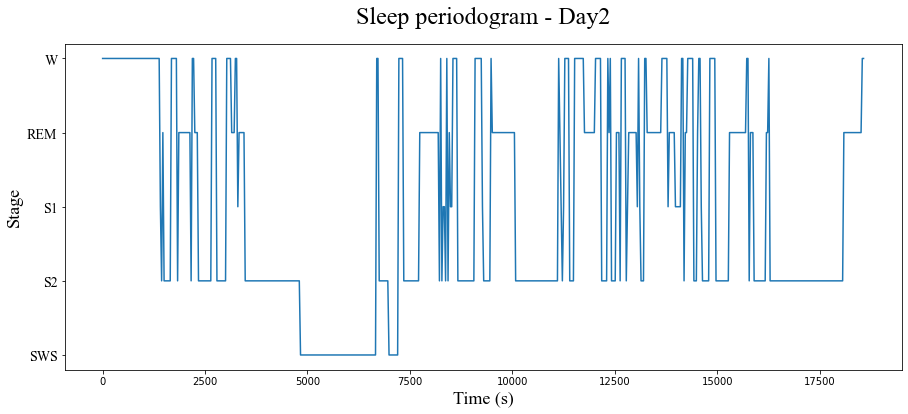

In [276]:
font_title = {'family': 'Times New Roman', 'weight': 'normal', 'size': 24}
font_tick = {'family': 'Times New Roman', 'weight': 'normal', 'size': 18}
s1 = np.where(pred==0)[0]
sws = np.where(pred==2)[0]
pred[s1] = 2
pred[sws] = 0
plt.figure(figsize=(15, 6))
plt.plot(range(0,30*len(pred),30),pred)
plt.title('Sleep periodogram - Day2', fontdict=font,pad=20)
plt.xlabel('Time (s)',fontdict=font_tick)
plt.ylabel('Stage',fontdict=font_tick)
plt.yticks([4, 3, 2, 1, 0], ['W', 'REM', 'S1', 'S2', 'SWS'],fontproperties = 'Times New Roman', size = 14)